In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
import imageio.v2 as imageio
from IPython import display

In [85]:
class Truss:
    """Object that represents a bridge truss, can calculate its forces and
    optimize the locations of its nodes."""

    def __init__(self, nodes : np.ndarray, edges : np.ndarray) -> None:
        """Nodes: Nx2 np array of X,Y coord pairs.
        Edges: Mx2 array of (i,j) edge pairs"""
        self.n_nodes = len(nodes)
        self.n_edges = len(edges)
        assert nodes.shape == (self.n_nodes, 2)
        assert edges.shape == (self.n_edges, 2)

        # nodes are stored as list of tensors so that some can require gradients, but others not
        self.node_tensors = [torch.tensor(node, requires_grad=True) for node in nodes]
        self.edges = edges
        self.loads = []
        self.anchors : list[tuple] = []
        self.forces = None
        self._validate_edges()
    
    def _validate_edges(self) -> None:
        """Asserts that all edges make sense and have no duplicates"""
        edge_set = set()
        for i, j in self.edges:
            assert 0 <= i < self.n_nodes, f"index error: {i}"
            assert 0 <= j < self.n_nodes, f"index error for {j}"
            edge = frozenset((i, j))
            assert edge not in edge_set, f"Duplicate edge {(i,j)}!"
            edge_set.add(edge)
    
    def add_load(self, node_idx : int, fx : float, fy : float):
        """Adds a force acting on the given node"""
        assert 0 <= node_idx < self.n_nodes
        self.loads.append((node_idx, fx, fy))

        # don't allow moving loads, because they'll just be moved to the anchors
        self.node_tensors[node_idx].requires_grad = False

    def add_anchor(self, node_idx : int, x_set : bool = True, y_set : bool = True):
        """Sets node at idx to be an anchor in possibly the x and y dimensions.
        An anchor node does not need to reach equilibrium, because any
        excess force will be taken in by the ground. It should not be
        included in the system of equations!"""
        assert 0 <= node_idx < self.n_nodes
        self.anchors.append((node_idx, x_set, y_set))

        # don't allow moving anchors, because they'll just be moved to the load
        self.node_tensors[node_idx].requires_grad = False
    
    def draw(self, ax=None) -> None:
        """Draws the graph and the forces on it:
        ax: allow passing in a matplotlib axes, to reuse it when drawing in a loop"""
        if ax is None:
            fig, ax = plt.subplots()
        plt.axis('equal')

        # get values out of tensor list
        xs = np.array([n[0].detach() for n in self.node_tensors])
        ys = np.array([n[1].detach() for n in self.node_tensors])
        
        # draw edges
        if self.forces is None:
            for i, j in self.edges:
                plt.plot(xs[[i, j]], ys[[i, j]] , 'k-', zorder=-1)
        else:
            for (i, j), f in zip(self.edges, self.forces):
                color = 'r' if f > 0 else 'b'  # red for compression, blue for tension
                plt.plot(
                    xs[[i, j]], ys[[i, j]], 
                    f'{color}-',
                    linewidth=abs(f) + 0.1, # still render things of zero force
                    zorder=-1)

        # draw loads
        for idx, fx, fy in self.loads:
            fx /= 10
            fy /= 10
            plt.arrow(xs[idx] - fx, ys[idx] - fy, fx, fy,  # subtract force to put tip at node
                head_width = 0.2,
                width = 0.05,
                color='green',
                length_includes_head=True)
            
        # draw anchors
        for idx, x_constrained, y_constrained in self.anchors:
            constrained_size = 0.1
            unconstrained_size = 0.3
            width = constrained_size if x_constrained else unconstrained_size
            height = constrained_size if y_constrained else unconstrained_size

            center = (xs[idx] - width / 2, ys[idx] - height / 2)
            ax.add_patch(Rectangle(center, width, height, edgecolor="green", facecolor="green"))
        
        # draw nodes
        plt.scatter(xs, ys)
            
    def _get_unit_xy(self, dx, dy):
        """Return the unit components of x, y normalized by total vector length"""
        hypot = torch.sqrt(dx**2 + dy**2)
        return dx / hypot, dy / hypot

    def calculate_forces(self):
        """Computes the force on each beam!
        Construct a matrix A representing system of equations, and solve.
        A @ Force_Vec = Load_vec
        Positive forces are compression, negative are tension.
        """

        # create design matrix
        A = torch.zeros((2 * self.n_nodes, self.n_edges))
        for edge_i, (n1_i, n2_i) in enumerate(self.edges):

            n1x, n1y = self.node_tensors[n1_i]
            n2x, n2y = self.node_tensors[n2_i]
            ux, uy = self._get_unit_xy(n1x - n2x, n1y - n2y)

            # towards N1
            A[n1_i * 2][edge_i], A[n1_i * 2 + 1][edge_i] = ux, uy

            # towards N2
            A[n2_i * 2][edge_i], A[n2_i * 2 + 1][edge_i] = -ux, -uy

        # construct load vector
        load_vec = torch.zeros((2 * self.n_nodes, 1))  # stored as [x1,y1,x2,y2...]
        for idx, fx, fy in self.loads:
            load_vec[idx * 2] += fx
            load_vec[idx * 2 + 1] += fy
        
        # handle anchor points: anchor points can have any force, so they can simply be
        # removed from the system of equations!
        # Zeroing instead of removing to preserve indexing...
        for node_idx, x, y in self.anchors:
            if x:
                A[node_idx * 2, :] = 0.0
                load_vec[node_idx * 2] = 0.0  # loads on anchor points are irrelevant
            if y:
                A[node_idx * 2 + 1, :] = 0.0
                load_vec[node_idx * 2 + 1] = 0.0  # loads on anchor points are irrelevant
        
        # use gelsd solver to handle non-full rank matrices
        self.forces, residuals, rank, s = torch.linalg.lstsq(A, -load_vec, rcond=None, driver='gelsd')
        
        # # Uncomment to debug system solving
        # print(f"{A=}")
        # print(f"{self.forces=}")
        # print(f"{residuals=}")
        # print(f"{rank=}")
        # print(f"{s=}")
        # print(f"{A@self.forces=}")

        residual_threshold = 0.1
        if len(residuals) > 0 and residuals.item() > residual_threshold:
            raise ValueError("Nodes could not reach equilibrium!")

        return self.forces
    
    def get_cost(self):
        """Calculates the cost of the truss from the lengths and forces.
        Tension weight = length * force / 1
        compression weight = length * force / (3 / (length + 3))
        """
        self.calculate_forces()

        lengths = torch.zeros_like(self.forces)
        for i, (n1, n2) in enumerate(self.edges):
            lengths[i] = torch.linalg.norm(self.node_tensors[n1] - self.node_tensors[n2])
    
        weights = torch.zeros_like(lengths)

        # beams in tension
        weights = lengths * torch.abs(self.forces)

        # compression
        fall_off = 3.0
        weights[self.forces > 0] *= (lengths[self.forces > 0] + fall_off) / fall_off

        return torch.sum(weights)
    
    def get_params(self):
        """Returns a list of all nodes that require a gradient"""
        return [n for n in self.node_tensors if n.requires_grad]
    
    def optimize(self, n_frames=200, render_live=True, save_gif=True, gif_path="output/animation.gif"):
        """Optimizes the truss and optionally saves a gif of the process"""
        frame_folder = 'output/frames/'

        # no momentum
        optimizer = torch.optim.Adam(params=self.get_params(), lr=0.005, betas=(0.0, 0.0))

        if render_live or save_gif:
            fig, ax = plt.subplots()

        for i in range(n_frames):
            cost = self.get_cost()

            if render_live or save_gif:
                plt.cla()
                self.draw(ax)
                
                if save_gif:
                    plt.savefig(f"{frame_folder}frame_{i}.png")
                if render_live:
                    display.display(plt.gcf())
                    display.clear_output(wait=True)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        if save_gif:
            if not render_live:
                plt.close()

            # Compile frames into a GIF
            frames = []
            for i in range(n_frames):
                frames.append(imageio.imread(f"{frame_folder}frame_{i}.png"))
            imageio.mimsave(gif_path, frames, format='GIF', fps=30, loop=0) # Adjust fps as needed


# Examples

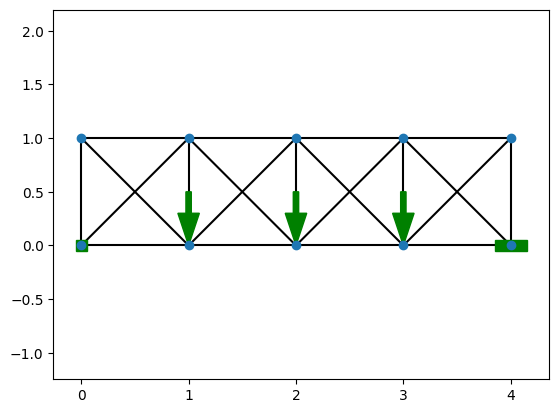

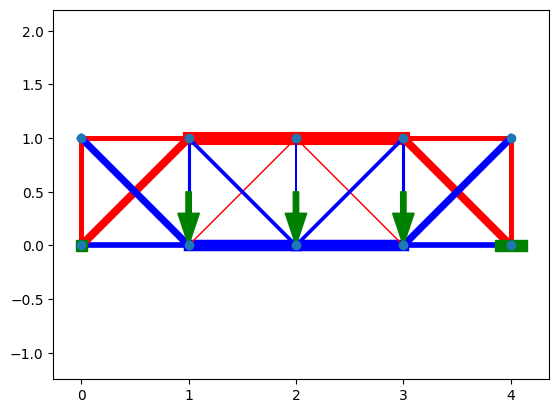

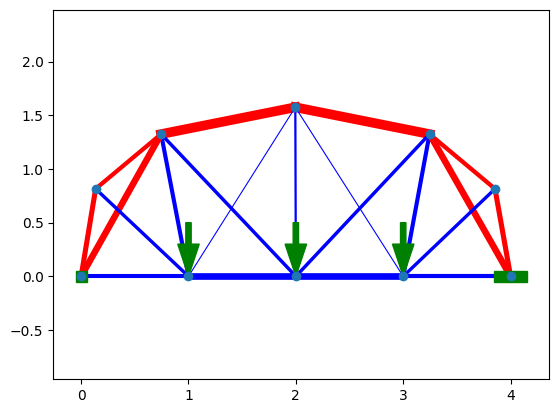

In [75]:
# Bridge
node_tensors = np.array([
    (0.0, 0.0),
    (0.0, 1.0), 
    (1.0, 0.0),
    (1.0, 1.0), 
    (2.0, 0.0),
    (2.0, 1.0), 
    (3.0, 0.0),
    (3.0, 1.0), 
    (4.0, 0.0),
    (4.0, 1.0), 
])
edges = np.array((
    (0,2), (2,4), (4,6), (6,8),
    (1,3), (3,5), (5,7), (7,9),
    (0,1), (2,3), (4,5), (6,7), (8,9),
    (0,3), (2,5), (5,6), (7,8),
    (1,2),(3,4),(4,7),(6,9)
))
t = Truss(node_tensors, edges)


t.add_load(2, 0, -5)
t.add_load(4, 0, -5)
t.add_load(6, 0, -5)
t.add_anchor(0)
t.add_anchor(8,x_set=False)
t.draw()
t.calculate_forces()
t.draw()

t.optimize(render_live=True,save_gif=False)

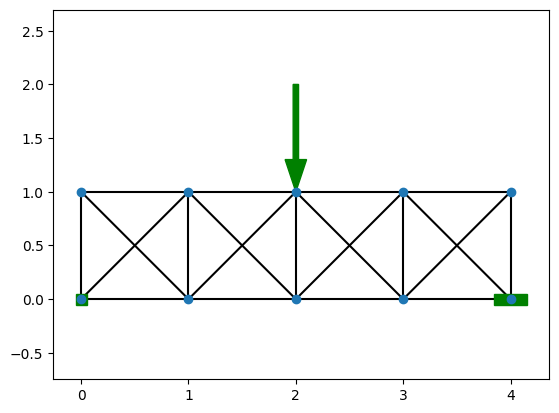

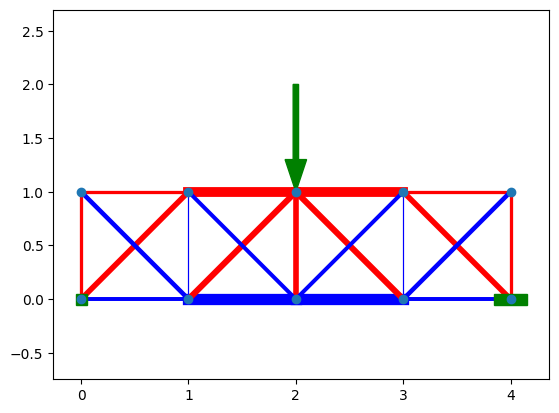

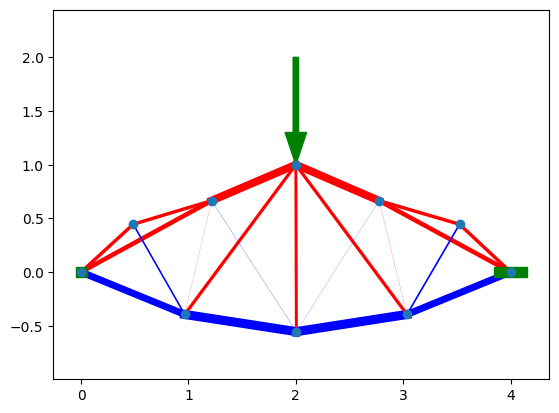

In [79]:
# Holding a point load
node_tensors = np.array([
    (0.0, 0.0),
    (0.0, 1.0), 
    (1.0, 0.0),
    (1.0, 1.0), 
    (2.0, 0.0),
    (2.0, 1.0), 
    (3.0, 0.0),
    (3.0, 1.0), 
    (4.0, 0.0),
    (4.0, 1.0), 
])
edges = np.array((
    (0,2), (2,4), (4,6), (6,8),
    (1,3), (3,5), (5,7), (7,9),
    (0,1), (2,3), (4,5), (6,7), (8,9),
    (0,3), (2,5), (5,6), (7,8),
    (1,2),(3,4),(4,7),(6,9)
))
t = Truss(node_tensors, edges)


t.add_load(5, 0, -10)
t.add_anchor(0)
t.add_anchor(8,x_set=False)
t.draw()
t.calculate_forces()
t.draw()

t.optimize(render_live=True,save_gif=False)

Starting cost: 404.5389709472656
Optimized cost: 362.8876037597656


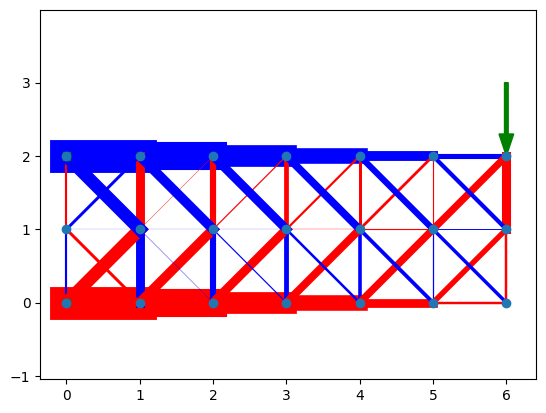

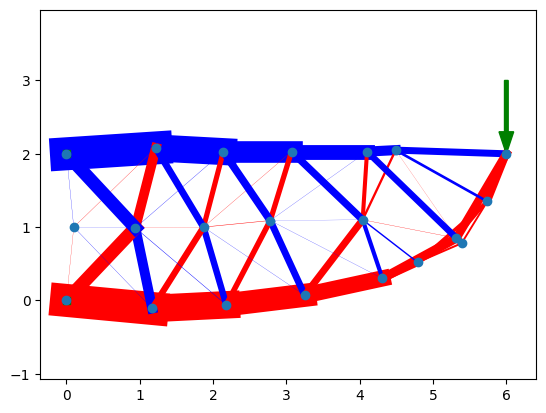

In [90]:
# big cantilever

node_tensors = np.array([
    (0.0, 0.0), # 0
    (0.0, 1.0), 
    (0.0, 2.0),
    (1.0, 0.0), # 3
    (1.0, 1.0), 
    (1.0, 2.0),
    (2.0, 0.0), # 6
    (2.0, 1.0), 
    (2.0, 2.0),
    (3.0, 0.0),
    (3.0, 1.0), 
    (3.0, 2.0),
    (4.0, 0.0),
    (4.0, 1.0), 
    (4.0, 2.0),
    (5.0, 0.0),
    (5.0, 1.0), 
    (5.0, 2.0),
    (6.0, 0.0),
    (6.0, 1.0), 
    (6.0, 2.0),
])
edges = np.array((
    # rows
    (0,3), (3,6), (6,9), (9,12), (12,15), (15,18),
    (1,4), (4,7), (7,10), (10,13), (13,16),(16,19),
    (2,5), (5,8), (8,11), (11,14), (14,17),(17,20),
    # cols
    (0,1), (1,2), (3,4), (4,5), (6,7), (7,8),
    (9,10),(10,11),(12,13),(13,14),(15,16),(16,17),(18,19),(19,20),
    # diags
    (0,4),(1,5),(3,7),(4,8),(6,10),(7,11),(9,13),(10,14),(12,16),(13,17),(15,19),(16,20),
    (1,3),(2,4),(4,6),(5,7), (7,9),(8,10),(10,12),(11,13), (13,15),(14,16),(16,18),(17,19),
))
t = Truss(node_tensors, edges)


t.add_load(20, 0, -10)
t.add_anchor(0)
t.add_anchor(2)
print(f"Starting cost: {t.get_cost().item()}")
t.draw()
t.optimize(save_gif=False, render_live=False)
print(f"Optimized cost: {t.get_cost().item()}")
t.draw()

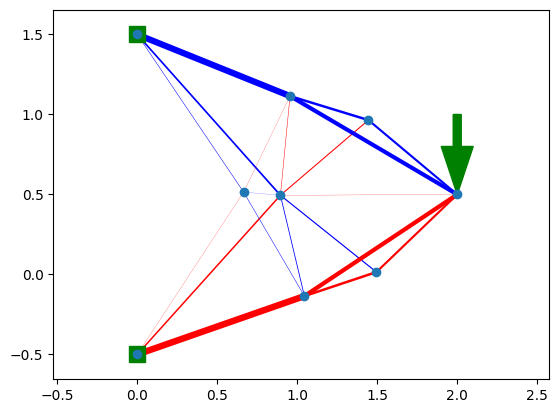

In [76]:
# holding a side load
node_tensors = np.array([
    (0.0, 0.0),
    (0.0, 1.0), 
    (0.0, 2.0),
    (1.0, 0.0), 
    (1.0, 1.0),
    (1.0, 2.0),
    (2.0, 0.0),
    (2.0, 1.0),
    (2.0, 2.0),
]) - np.array([[0,.5]])
edges = np.array([
    (0,1),(1,2),(3,4),(4,5),(6,7),(7,8),
    (0,3),(1,4),(2,5),(3,6),(4,7),(5,8),
    (0,4),(4,8),(2,4),(6,4),
    (1,3),(1,5),(5,7),(3,7),
])
t = Truss(node_tensors, edges)


t.add_load(7, 0, -5)
t.add_anchor(0)
t.add_anchor(2)

t.optimize(save_gif=False)

# Unit Tests!

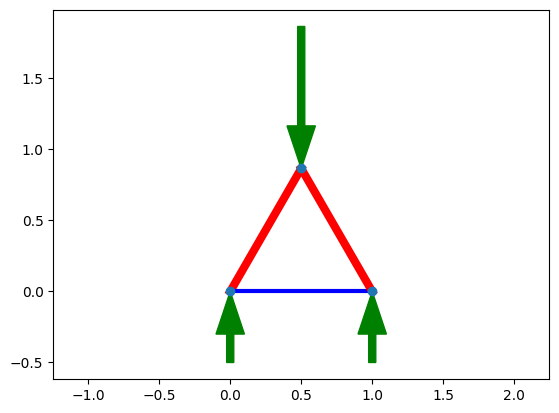

In [69]:
# Equilateral triangle test with pure forces
node_tensors = np.array((
    (0.5, np.sin(2*np.pi/3)),
    (0, 0), 
    (1, 0),
))
edges = np.array(((0,1), (1, 2), (2, 0)))
t = Truss(node_tensors, edges)

t.add_load(0, 0, -10)
t.add_load(1, 0, 5)
t.add_load(2, 0, 5)

forces = t.calculate_forces()
t.draw()
expected = np.array([[5.77350269, -2.88675135, 5.77350269]]).T
assert sum((forces - expected)**2) < 0.001

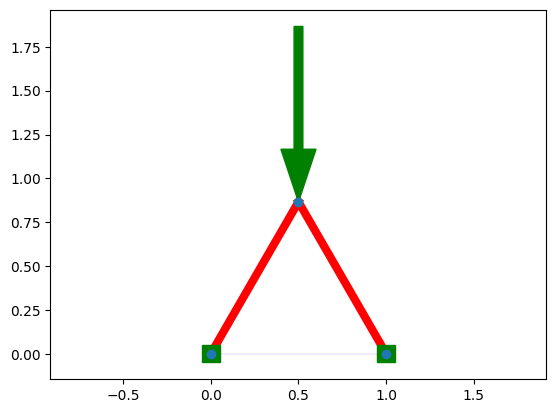

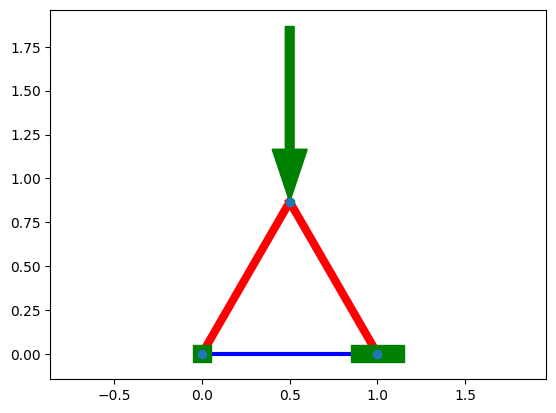

In [70]:
# Equilateral triangle test with anchors
node_tensors = np.array((
    (0.5, np.sin(2*np.pi/3)),
    (0, 0), 
    (1, 0),
))
edges = np.array(((0,1), (1, 2), (2, 0)))

# two full anchors
t = Truss(node_tensors, edges)
t.add_load(0, 0, -10)
t.add_anchor(1)
t.add_anchor(2)

forces = t.calculate_forces()
t.draw()
expected = torch.tensor([[5.77350269, 0, 5.77350269]]).T
assert sum((forces - expected)**2) < 0.001

# 1 partial anchor
t = Truss(node_tensors, edges)

t.add_load(0, 0, -10)
t.add_anchor(1)
t.add_anchor(2, x_set=False)

forces = t.calculate_forces()
t.draw()
expected = torch.tensor([[5.77350269, -2.88675135, 5.77350269]]).T
assert sum((forces - expected)**2) < 0.001

correctly threw error


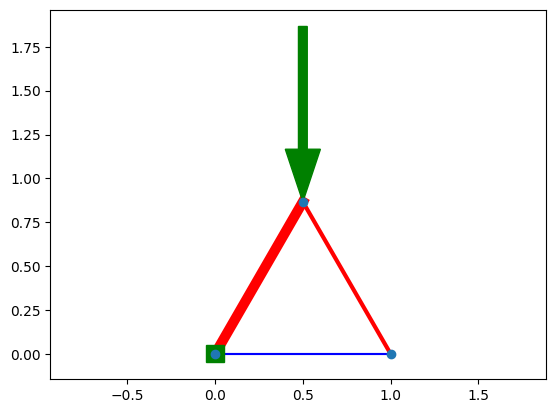

In [71]:
# under constrained example
node_tensors = np.array((
    (0.5, np.sin(2*np.pi/3)),
    (0, 0), 
    (1, 0),
))
edges = np.array(((0,1), (1, 2), (2, 0)))

# two full anchors
t = Truss(node_tensors, edges)
t.add_load(0, 0, -10)
t.add_anchor(1)
# t.add_anchor(2)

try:
    forces = t.calculate_forces()
    assert False, "should have thrown value error"
except ValueError:
    print("correctly threw error")
t.draw()

tensor([[2.7348, 3.4813, 5.0138]])


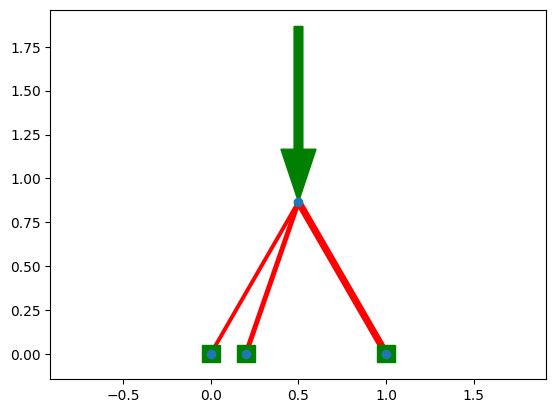

In [72]:
# Over constrained example
node_tensors = np.array((
    (0.5, np.sin(2*np.pi/3)),
    (0, 0), 
    (.2, 0),
    (1, 0),
))
edges = np.array(((0,1), (0, 2), (0, 3)))

# two full anchors
t = Truss(node_tensors, edges)
t.add_load(0, 0, -10)
t.add_anchor(1)
t.add_anchor(2)
t.add_anchor(3)

forces = t.calculate_forces()
t.draw()
print(forces.T)
assert all(forces > 2.0), "force should be among all beams"

# Compression vs Tension

cost: 18.282764434814453


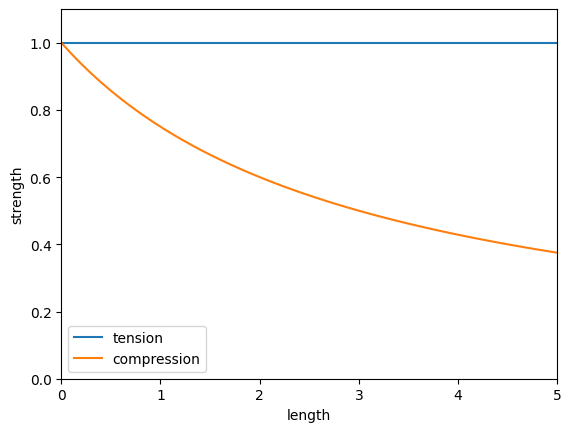

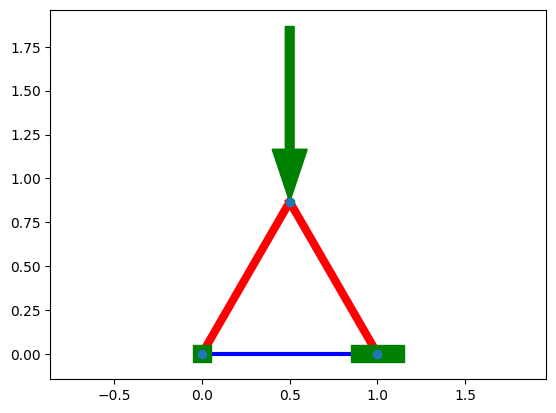

In [74]:
# How strong is a beam of different length?
lengths = np.linspace(0,5, 50)
tensions = np.ones_like(lengths)
fall_off = 3.0
compressions = fall_off / (lengths + fall_off)

plt.plot(lengths, tensions, label='tension')
plt.plot(lengths, compressions, label='compression')
plt.axis((0,5,0,1.1))
plt.xlabel("length")
plt.ylabel("strength")
plt.legend()

node_tensors = np.array((
    (0.5, np.sin(2*np.pi/3)),
    (0, 0), 
    (1, 0),
))
edges = np.array(((0,1), (1, 2), (2, 0)))

t = Truss(node_tensors, edges)

t.add_load(0, 0, -10)
t.add_anchor(1)
t.add_anchor(2, x_set=False)

print(f"cost: {t.get_cost()}")
t.draw()

# Gif Editing

In [87]:
# saving gif example
import matplotlib.pyplot as plt
import imageio

# Example data
x_set = [1, 2, 3, 4, 5]
y = [2, 3, 2, 3, 2]

# File paths
frame_folder = 'output/frames/'
gif_path = 'output/animation.gif'

# Create and save frames
for i in range(len(x_set)):
    plt.figure()
    plt.plot(x_set[:i+1], y[:i+1])
    # You can add more plotting logic here
    plt.savefig(f"{frame_folder}frame_{i}.png")
    plt.close()

# Compile frames into a GIF
frames = []
for i in range(len(x_set)):
    frames.append(imageio.imread(f"{frame_folder}frame_{i}.png"))
imageio.mimsave(gif_path, frames, format='GIF', fps=5) # Adjust fps as needed


/tmp/ipykernel_81141/4263478732.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(f"{frame_folder}frame_{i}.png"))


In [23]:
# trim gifs
gif = imageio.mimread('output/final_gifs/simple_cant.gif', memtest=False)

imageio.mimsave(
    'output/final_gifs/simple_cant_trim.gif', 
    gif[1:180], format='GIF', fps=30, loop=0)

In [26]:
# combining gifs
names = [
    'double_truss_2', 
    'cantilever_2_trim',
    'down_press_trim', 
    'simple_cant_trim',
    'tension_arch_3', 
]

combined_gif = []

for name in names:
    gif1 = imageio.mimread(f"output/final_gifs/{name}.gif")
    combined_gif += gif1[1:]

# Save the combined GIF
imageio.mimsave("output/final_gifs/combo.gif", combined_gif, 
                format='GIF', fps=30, loop=0)